# K近傍法 & 教師あり学習のお作法

このHands-onでは下記3種類のデータを用いて，K近傍法と教師あり学習のお作法について体験する．
* 手書き数字画像
* 人工的に作られたある2次元データ
* ある時期のアメリカ合衆国の年収調査データ

Hands-onに先立って，必要なライブラリを読み込んでおこう．


In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# データセット
from sklearn import datasets

# K近傍法を実行するためのクラス
from sklearn.neighbors import KNeighborsClassifier

# 交差検証を行うためのクラス
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_validate

# 精度，マクロ精度，適合率，AUCを評価するための関数
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, roc_auc_score

# データ変換のためのクラス
import sklearn.preprocessing as preprocessing

# データ分割のための関数
from sklearn.model_selection import train_test_split

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


---
## 例題1: MNIST手書き数字データ

例題1では，K近傍法を用いて手書き数字の識別の体験をする．
用いるデータは，かの有名な[MNISTデータセット](http://yann.lecun.com/exdb/mnist/)である．
今回は，`scikit-learn`ライブラリに梱包された8x8ピクセルの領域に描かれた手書き数字のグレースケール画像のデータセットを用いる．
データセット中の手書き数字は**0から9の数**に対応している．
また，手書き画像データは**各ピクセルに0から255の数値**が割り当てられており，その数字によって白黒の濃淡がつけられている（0が黒，255が白に対応）．

以下のコードを実行してMNISTデータセットを読み込もう．

In [2]:
mnist_dataset = datasets.load_digits()
X = mnist_dataset.data
y = mnist_dataset.target

変数`X`は行列（numpy.ndarray）で，各行が手書き数字画像，各行がピクセルに対応している．
変数`y`には，各行の手書き数字画像に対応する数字（ラベル）のリストが格納されている．

今回対象とする手書き数字画像は8x8ピクセルの画像である．
画像を計算可能なデータとして表現する場合，行列を用いて画像中の各ピクセルの色を表現する方法が直感に合う．
しかし，MNISTデータセットでは，データを扱いやすくするために8x8ピクセルの画像を1x64の横ベクトルで表現している．

描きコードを実行して，`X`には何件の手書き数字画像が格納されているのか確認してみよう．

In [3]:
X.shape

(1797, 64)

`X`の行列のサイズが表示された．
行が1797，列が64なので，手書き画像のデータ数は1797のようである．

行列`X`に格納されたデータを眺めてみよう．
描きコードを実行して，51番目に格納された手書き数字画像データを確認してみよう．

In [4]:
# 51番目のデータに対応するインデックス（行列は0行目から始まるので50ではなく51）
k = 50

# ターゲットとなる画像データとラベルを変数に格納
target_data = X[k, :]
target_label = y[k]

print("{}番目の手書き数字 = ".format(k+1), target_label)

# 51番目の画像データ（各ピクセルの値）
target_data

51番目の手書き数字 =  2


array([ 0.,  0.,  0.,  5., 14., 12.,  2.,  0.,  0.,  0.,  7., 15.,  8.,
       14.,  4.,  0.,  0.,  0.,  6.,  2.,  3., 13.,  1.,  0.,  0.,  0.,
        0.,  1., 13.,  4.,  0.,  0.,  0.,  0.,  1., 11.,  9.,  0.,  0.,
        0.,  0.,  8., 16., 13.,  0.,  0.,  0.,  0.,  0.,  5., 14., 16.,
       11.,  2.,  0.,  0.,  0.,  0.,  0.,  6., 12., 13.,  3.,  0.])

51番目の画像データの中身とそれに対応する数字が表示された．
画像データの横ベクトルが意味が分からないので，8x8の行列に直してみよう．
以下のコードを実行すると，行列の形を1x64から8x8に変更できる．

In [5]:
# numpy行列のshapeメソッドは行列の形を変換する
target_matrix = target_data.reshape(8, 8)
target_matrix

array([[ 0.,  0.,  0.,  5., 14., 12.,  2.,  0.],
       [ 0.,  0.,  7., 15.,  8., 14.,  4.,  0.],
       [ 0.,  0.,  6.,  2.,  3., 13.,  1.,  0.],
       [ 0.,  0.,  0.,  1., 13.,  4.,  0.,  0.],
       [ 0.,  0.,  1., 11.,  9.,  0.,  0.,  0.],
       [ 0.,  8., 16., 13.,  0.,  0.,  0.,  0.],
       [ 0.,  5., 14., 16., 11.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  6., 12., 13.,  3.,  0.]])

どのピクセルにどのような値がセットされているのか分かりやすくなったが，視覚的にどうなっているのか全然分からない．
下記コードを実行して行列データを可視化してみよう．

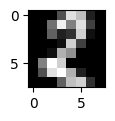

In [6]:
fig = plt.figure(figsize=(2, 1))
plt.imshow(target_matrix, cmap=plt.cm.gray, interpolation='none')
plt.show()

8x8ピクセルなので荒くて分かりづらいが，遠目で見ると「2」という数字に見える．

### 学習

データの中身の理解が進んだので，K近傍法を用いて手書き数字画像の分類器を構築してみよう．
授業でも説明したように，教師あり学習を行いモデル構築とモデル評価を行うには訓練データとテストデータが必要になる．

`sklearn`ライブラリには，データセットを訓練データとテストデータに分割する便利な関数`train_test_split`がある．
下記コードを実行して，手元にあるデータセットを「訓練データ」と「テストデータ」に分割してみよう．


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # データセットを訓練データ80%，テストデータ20%に分割
    shuffle=True,  # 分割時にはデータセットをシャッフル
    stratify=y)    # ラベルの分布が訓練データとテストデータで同じになるようにする

`train_test_split`関数の第1引数，第2引数にセットされた`X`と`y`について，
* 80%が訓練データ: `X_train`（画像データ）と`y_train`（対応するラベル）
* 20%がテストデータ: `X_test`（画像データ）と`y_test`（対応するラベル）

に分割された．
本当にデータセットは80:20に分割されているか確認してみよう．

In [8]:
print("訓練データのサイズ", len(y_train))
print("テストデータのサイズ", len(y_test))

訓練データのサイズ 1437
テストデータのサイズ 360


大体80:20に分割されていることが分かる．

先の`train_test_split`関数の実行時には，stratify（層別化）オブションを有効にしていた．
下記のコードを実行して，ラベルの分布が訓練データとテストデータで同じになっているか，確認しておこう．

In [9]:
# 訓練データの分布
keys, counts = np.unique(y_train, return_counts=True)
for key, count in zip(keys, counts):
    print(key, ":", count)

0 : 142
1 : 145
2 : 142
3 : 146
4 : 145
5 : 146
6 : 145
7 : 143
8 : 139
9 : 144


In [10]:
# テストデータの分布
keys, counts = np.unique(y_test, return_counts=True)
for key, count in zip(keys, counts):
    print(key, ":", count)

0 : 36
1 : 37
2 : 35
3 : 37
4 : 36
5 : 36
6 : 36
7 : 36
8 : 35
9 : 36


訓練データもテストデータも，0から9までの手書き数字データがほぼ均等に分布していることが確認できる．

それでは，K近傍法で手書き数字画像の分類器を構築しよう．
MNISTデータセットはデータがキレイなため，特に前処理を行わなくても`sklearn`ライブラリを使えば分類器の構築は数行で終わってしまう．

今回はK近傍法のパラメータは
* 近傍数`K`: 5
* 距離関数`metric`: euclidean（ユークリッド距離）

とし，以下のコードを実行して分類器を構築してみよう．

In [11]:
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

K近傍法による分類器が構築できた．

それではテストデータから適当にピックアップし，分類器で正しく数値分類できるか確認してみよう．
下記コードを実行すると，テストデータからランダムに3個データを取得し，構築した分類器による予測を行える．

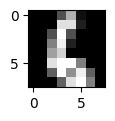

予測ラベル:  [6]
正解ラベル:  6


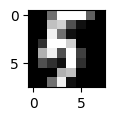

予測ラベル:  [5]
正解ラベル:  5


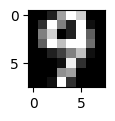

予測ラベル:  [9]
正解ラベル:  9


In [12]:
import random

test_size = len(y_test)
for _ in range(3):
    idx = random.randint(0, test_size-1) # 何番目のテストデータか
    target_data = X_test[idx, :].reshape(1, 64)
    target_label = y_test[idx]

    # K近傍法による推論
    y_predicted = knn_model.predict(target_data)

    # 手書き数字画像を表示
    fig = plt.figure(figsize=(2, 1))
    plt.imshow(target_data.reshape(8, 8), cmap=plt.cm.gray, interpolation='none')
    plt.show()
    
    # 推論結果と正解ラベルの表示
    print("予測ラベル: ", y_predicted)
    print("正解ラベル: ", target_label)

どんな分類結果が得られただろうか．
（位置が調整された）手書き数字画像であれば，単純なK近傍法であっても正確にラベルを予測することができそうだ．


---
## 例題2: 人工的に作られたある2次元データ

次の例題では，機械学習の手順や評価指標の重要性を体験してみよう．
この例題で用いるのは，この例題のために作成した二次元データである．
データの値に特に意味はない．
以下のコードを実行して，データを読み込もう．

In [13]:
url = "https://raw.githubusercontent.com/hontolab-courses/ml-lecturenote/refs/heads/main/content/data/imbalanced-data.tsv"
scatter_df = pd.read_table(url, header=0, sep='\t')
scatter_df

,label,x1,x2
0,0,10.922188,11.037222
1,0,5.560963,-1.993854
2,1,-0.172181,2.659002
3,0,9.094238,-0.180836
4,0,-1.802328,5.721992
...,...,...,...
103,1,-2.940544,5.098511
104,0,8.265318,11.367254
105,1,4.993353,8.362569
106,0,8.472310,11.346936


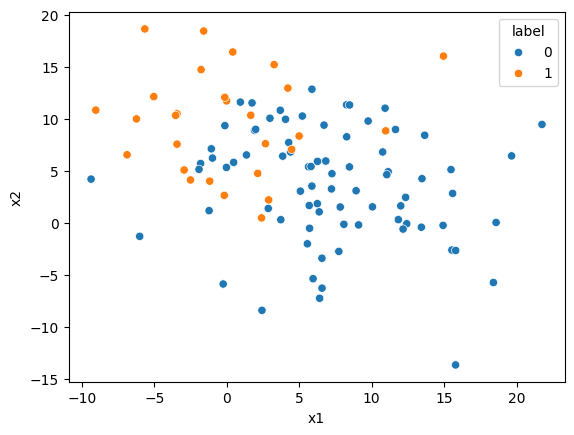

In [14]:
sns.scatterplot(x='x1', y='x2', hue='label', data=scatter_df)
plt.show()

変数`scatter_df`には，ラベル0とラベル1のデータ点が合計108個格納されている．
ラベルの分布を以下のコードを実行して確認してみよう．

In [15]:
keys, counts = np.unique(scatter_df.label, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 80
Label 1 = 28


ラベル1のデータがラベル0の3分の1程度しかなく，データの分布が偏っていることが分かる（[★Quiz 1](#L5-Q1)，[★Quiz 2](#L5-Q2)，[★Quiz 3](#L5-Q3)）．

ではK近傍法を用いて，ラベルの分類器を構築してみよう．
この例題では`K=5`としてK近傍法を用いる．
今回はまず**誤った手続き**で分類器を構築・評価してみよう．

### 誤った手続き1: 交差検証を行わない

誤った手続きその1は「交差検証を行わない」である．
用意したデータセットのサイズが十分に大きい場合，あるいはデータセットの準備の時点で訓練データとテストデータが分けて得られている場合は交差検証にこだわる必要はそれほどないかもしれない．
そうでない場合は，交差検証をしなければ，分類器の汎化性能および性能評価そのものに問題が生じる．

以下は交差検証を行わない，誤った教師あり学習の手続きである．

In [16]:
# データ準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# データセットを70:30で訓練データ，評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 学習
knn_model.fit(X_train, y_train)

# 推論
y_predicted = knn_model.predict(X_test)

# 評価
accuracy = accuracy_score(y_test, y_predicted)
print("kNN accuracy: ", accuracy)

kNN accuracy:  0.8787878787878788


評価指標として精度（accuracy）を用いて，交差検証を行わずに分類器の構築と評価を行っている．
みなさんの環境では適合率はいくつになっただろうか．
他の人と比べたり，上記コードを再度実行してみよう．
適合率が安定しない（変化する）ことに気付くはずだ．

十分に大きくないデータセットに対して**交差検証を用いない場合，訓練データとテストデータの中身の分布に偏りが生じる**．
その影響がモデルの構築および性能評価に出て，偶然結果が良くなったり悪くなったりする．
分割した訓練データと評価データのラベルの分布を確認してみよう．


In [17]:
# 訓練データの分布
keys, counts = np.unique(y_train, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 57
Label 1 = 18


In [18]:
# テストデータの分布
keys, counts = np.unique(y_test, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 23
Label 1 = 10


今回は`train_test_split`関数を用いるときにランダムにテストデータを分割している．
そのため，人によっては訓練データとテストデータのラベルの分布が同じようになったケースもあるかもしれないが，データの分割の仕方で毎回性能評価値が大きく変わったように見えるのはよろしくない．
信頼できる性能評価を行うためにも，交差検証を行う必要がある．

さて，上記の「誤った手続き」のコードは，交差検証のやり方以外にも問題がある．
次の「誤った手続き」で見てみよう．

### 誤った手続き2: 層別化を行わない

誤った手続きその2は「層別化を行わない」である．
今回用意したデータセットのようにラベルの分布に偏りがある場合は，その分布を考慮して訓練データとテストデータを分割しなければ，たまたま都合の良い（あるいは悪い）分類器を構築し，たまたま都合の良い（あるいは悪い）性能評価を行ってしまう．
そのため，モデルの汎化性能を高めるためにも，信頼できる性能評価を行うためにも，**層別化**を行いながら訓練データとテストデータの分割を行う必要がある．

以下は層別化を行わない交差検証を行った，誤った教師あり学習の手続きである．

In [19]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 層別化をしない5分割交差検証の準備（乱数を固定）
k_fold = KFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（精度）
score_funcs = ['accuracy']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Accuracy list: ", scores['test_accuracy'])

# 交差検証の評価スコアを平均としてまとめる
print("kNN accuracy: ", np.mean(scores['test_accuracy']))

Accuracy list:  [0.86363636 0.63636364 0.90909091 0.76190476 0.9047619 ]
kNN accuracy:  0.8151515151515152


上記コードではデータ分割と交差検証，分類器構築，分類器評価を簡単にまとめて実行できる`cross_validate`関数を使っている．
5分割交差検証の1回（ラウンド）ごとの精度スコアが`scores['test_accuracy']`に格納されている．
また，その平均値の計算も行っている．
一般に，交差検証を用いた性能評価では評価値の平均値を用いる．

もうお気づきのとおり，適合率のスコアが交差検証のラウンドごとに大きく異なる．
層別化を行っていないためである．
交差検証の平均スコアだけを見ていても，スコアが変動することに気付かないだろう．

このように，交差検証を行って学習と評価を複数回やったとしても，ラベル分布の偏りを考慮しなければ適切な学習，評価はできない．

### 誤った手続き3: 評価指標が適切でない

誤った手続きその3は「評価指標が適切でない」である．
以下は層別化交差検証を行ったが，単純な精度を評価指標に使ってしまった，誤った教師あり学習の手続きである．

In [20]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 「層別化」5分割交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（精度）
score_funcs = ['accuracy']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Accuracy list: ", scores['test_accuracy'])

# 交差検証の評価スコアを平均としてまとめる
print("kNN accuracy: ", np.mean(scores['test_accuracy']))

Accuracy list:  [0.72727273 0.81818182 0.77272727 0.76190476 0.80952381]
kNN accuracy:  0.7779220779220779


「誤った手続き2」よりも精度のばらつきが小さくなった．
これで平均値を取れば一見正しい評価をしたような気がするが，この例題の冒頭で解説したラベル分布の話を思い出してほしい．
このデータセットは，ラベル0のほうがラベル1よりも3倍程度多く含んでいる．．
極端な話として，分類器の予測結果が常に「ラベル0」を返したとしても，単純な精度は不当に高い値をはじき出してしまう．

今回用意したデータセットのようにラベルの分布に偏りがある場合は，単純な精度ではなくラベル分布の偏りを考慮した**マクロ精度**や**AUC**，**MCC（マシューズ相関係数）** を用いる必要がある．

以上を踏まえて，以下に「より妥当な手続き」のコードを記す．

### より妥当な手続き

In [21]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 5分割「層別化」交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（マクロ精度（balanced accuracy），AUC）
score_funcs = ['balanced_accuracy', 'roc_auc']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Balanced accuracy list: ", scores['test_balanced_accuracy'])
print("AUC list: ", scores['test_roc_auc'])

# 交差検証の評価スコアを平均としてまとめる
print()
print("Balanced accuracy: ", np.mean(scores['test_balanced_accuracy']))
print("AUC: ", np.mean(scores['test_roc_auc']))

Balanced accuracy list:  [0.65625    0.66666667 0.58333333 0.70625    0.66875   ]
AUC list:  [0.84375    0.765625   0.82291667 0.84375    0.84375   ]

Balanced accuracy:  0.65625
AUC:  0.8239583333333333


上記はラベルの分布を考慮した，より妥当な分類器の構築と性能評価の手続きである．

どんな分類器を構築するにしても，一般的には上記のように「層別化によるデータ分割」を「交差検証」を組み合わせたモデル構築と評価を行う（[★Quiz 4](#L5-Q4)）．
より高性能の分類器を構築するには，上記手続きに加え，
* データの変換（スケーリング，one-hotベクトル化）
* 欠損値への対応
* 特徴量選択
* パラメータチューニング（[★Quiz 5](#L5-Q5)）

などが必要となる．


---
## 例題3: ある時期のアメリカ合衆国の年収調査データ
最後の例題で扱うデータは，[1994年に作成されたアメリカ合衆国の国勢調査のデータセット（一部）](https://archive.ics.uci.edu/ml/datasets/Adult)である．
機械学習の研究分野では著名なデータセットで通称"Adult Dataset"と呼ばれている．
このデータセットには，
* 年齢
* 職業クラス
* 最終学歴
* 教育年数
* 婚姻ステータス
* 職業
* 家族の構成
* 人種
* 性別
* 資産売却益
* 資産売却損
* 週の労働時間
* 母国
* 年収（年5万ドル以上（>=50K） or それ以下（<50K））

に関する情報が含まれている．
このデータセットを使って，年収以外の情報から年収が年5万ドル以上か未満かを推定するさまざまな分類器を構築してみよう．

以下のコードを実行すると，不必要なデータ列を削除し，ターゲットとなる年収情報を
* 年5万ドル以上なら1
* 年5万ドル未満なら0

に置換したデータセットをデータフレーム変数`adult_df`に読み込む．

In [22]:
adult_dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

features = [
    "age",             # 年齢（数値）
    "workclass",       # 職業クラス（カテゴリカル）
    "fnlwgt",          # 不明
    "education",       # 最終学歴（カテゴリカル）
    "education_num",   # 教育年数（数値）
    "marital_status",  # 婚姻ステータス（カテゴリカル）
    "occupation",      # 職業（カテゴリカル）
    "relationship",    # 家族の構成（カテゴリカル）
    "race",            # 人種（カテゴリカル）
    "sex",             # 性別（カテゴリカル）
    "capital_gain",    # 資産売却益（数値）
    "capital_loss",    # 資産売却損（数値）
    "hours_per_week",  # 週の労働時間？（数値）
    "native_country",  # 母国（カテゴリカル）
    "annual_income"    # 年収（True of False）
]

adult_df = pd.read_table(
    adult_dataset_url, sep=", ", header=None,
    names=features, engine='python', na_values="?"
).assign(
    has_high_salary = lambda df: df["annual_income"].map({">50K": True, "<=50K": False})
).drop( # 不要 or 不明な特徴量を削除
    columns=['fnlwgt', 'annual_income']
)

読み込んだ`adult_df`を以下のコードで表示してみよう．
データは全部で32561レコードあることが分かる．

In [23]:
adult_df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,has_high_salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,False
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,True
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,False
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,False


今回の分類対象となる年収の分布を確認しておこう．
下記コードを実行し，`adult_df`中の`has_high_salary`の値の分布を調べてみよう．

In [24]:
keys, counts = np.unique(adult_df["has_high_salary"], return_counts=True)
for key, count in zip(keys, counts):
    ratio = count / len(adult_df) * 100
    print(key, ":", count, "({:.1f}%)".format(ratio))

False : 24720 (75.9%)
True : 7841 (24.1%)


年収が5万ドル以上のレコードと5万ドル未満のレコードの比は約1:3のようである．
データに偏りがあるので，この点を意識して分類器の構築・評価を行う必要がある．

では，先に進もう．
分類器を構築するためには，データセットを特徴データとラベルデータに分ける必要があった．
以下のコードを実行して，特徴量に関するデータを変数`X`に，ラベルデータを変数`y`に格納する．

In [25]:
# 最後の列の"has_high_salary"以外が特徴データ列
target_features = adult_df.columns[:-1]
X = adult_df[target_features] 

# ターゲットラベルは"has_high_salary"
y = adult_df["has_high_salary"] 

さて，`adult_df`を表示してお気づきのとおり，今回のデータセットには「年齢」「教育年数」「週の労働時間」のような**数値データ**もあれば，「職業クラス」「婚姻ステータス」「人種」のような**カテゴリカルデータ（質的データ）** も含まれてる．
カテゴリカルデータは数値ではないので，そのままでは数値処理を行うのが難しい．
そのため，機械学習を行うときにはカテゴリカルデータを**one-hotベクトル（one-hot表現，ダミー変数と呼ばれることもある）** に置き換える．

例えば，

| ID | 年齢| 最終学歴 |
| --- | --- | --- |
| 1 | 38 | 大学 |
| 2 | 58 | 高校 |
| 3 | 27 | 大学院 |

のようなデータセットがあった場合，最終学歴がカテゴリカルデータに相当する．
このデータセットをOne-hotベクトル化すると，以下のようになる．

| ID | 年齢| 最終学歴_大学 | 最終学歴_高校 |
| --- | --- | --- | --- |
| 1 | 38 | 1 | 0 |
| 2 | 58 | 0 | 1 |
| 3 | 27 | 0 | 0 | 

今回のデータセットもone-hotベクトル化してみよう．
`pandas`ライブラリには，データフレームの中で指定した列をone-hotベクトルに変換してくれる便利な関数`get_dummies`がある．
以下のコードを実行して，特徴データ`X`をone-hotベクトル化してみよう．

In [26]:
# ターゲットとなるカテゴリカルデータの特徴名（列名）
categorical_features = [
    "workclass",       # 職業クラス（カテゴリカル）
    "education",       # 最終学歴（カテゴリカル）
    "marital_status",  # 婚姻ステータス（カテゴリカル）
    "occupation",      # 職業（カテゴリカル）
    "relationship",    # 家族の構成（カテゴリカル）
    "race",            # 人種（カテゴリカル）
    "sex",             # 性別（カテゴリカル）
    "native_country",  # 母国（カテゴリカル）    
]

# Xのカテゴリカルデータ列をone-hotベクトル化
X_ = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# 最初の10件を表示
X_.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,13,2174,0,40,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


新たに得られたデータフレーム`X_`の`workclass`に関連する列に着目しよう．
元々は列`workclass`の値として"Local-gov"や"Never_worked"があったが，one-hotベクトル化されたデータフレーム`X_`では`workclass_Local-gov`などの列が新たに生成されていることが分かる．

カテゴリカルデータに対する前処理が終ったが，まだ分類器を構築することはできない．
データの正規化を行う必要がある．

One-hotベクトルは1もしくは0の値を取る．
一方で，データフレーム`X_`には「年齢」「週の勤務時間」「資産売却益」など，連続値を取る特徴量もある．
これらの特徴量はとり得る値の範囲やデータの分布，単位が特徴量ごとに大きく異なるため，特徴量（列）間の比較が難しくなり，機械学習の性能に悪影響が出る可能性がある．
このような問題に対処するために，データの**スケーリング**を行おう．

一般に，スケーリングの方法には
* 正規化: 最小値-最大値でスケーリングする方法
* 標準化: データの分布が平均0，標準偏差1になるようスケーリングする方法

の2種類がよく用いられる．
ここでは簡単のため，連続値データ列もone-hotベクトルデータ列もすべて標準化することにしよう．
以下のコードでデータを標準化する．


In [27]:
# 標準化のための変換器を用意
scaler = preprocessing.StandardScaler()

# 標準化
X_ = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)

データフレーム`X_`のデータが標準化された．

前処理が終わったので，K近傍法（K=5）を用いて分類器を構築してみよう．
分類器の性能評価は，5分割の層別化交差検証，評価指標は「マクロ精度（balanced accuracy）」「適合率（precision）」の2つを用いることにする．

やや長いが，下記コードを実行し，交差検証を用いて分類器の構築，性能評価をしてみよう

In [28]:
# 時間計測に使う
import time

# 評価スコアを入れる場所
accuracy_scores = []
precision_scores = []


# 5分割層別化交差検証
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kfold.split(X_, y):
    # train_idx, test_idxには，データフレーム中の何番目のデータを用いるかのリストが入っている．
    # 3つの分類器に対して同じデータを用いて評価すること．
    X_train = X_.iloc[train_idx]
    X_test = X_.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    # 学習
    model = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    model.fit(X_train, y_train)
    
    # 推論
    y_predicted = model.predict(X_test)
    
    # 評価スコアの計算
    precision = precision_score(y_test, y_predicted)
    precision_scores.append(precision)          
    accuracy = balanced_accuracy_score(y_test, y_predicted)
    accuracy_scores.append(accuracy)
    
    
# 交差検証の結果を平均して，最終の性能評価を算出
print("\n==== Precision =====")
print(np.mean(precision_scores))
    
print("\n==== Balanced accuracy =====")
print(np.mean(accuracy_scores))


==== Precision =====
0.6478086618557175

==== Balanced accuracy =====
0.7379965967294305


評価に用いたデータには年収の分布に偏りがあったため，どのカテゴリにも満遍なく予測ができるかを確認したいのであれば，適合率よりもマクロ精度をより重視した方がよい．
今回のHands-onコードでは，単純な手法であるK近傍法もそこまで悪くない性能を示している．
ハイパーパラメータの調整はしなかったので，どの分類器ももう少し性能改善の余地はあるだろう．

---

# クイズ

※ 以下のクイズの回答にGoogle Colaboratoryを使いたい方は[コチラ](https://colab.research.google.com/github/hontolab-courses/ml-lecturenote/blob/main/content/quiz/knn-and-ml-flow.ipynb)をクリック．


(L5-Q1)=
### Q1: 崩し字データのダウンロード

[Kuzushiji-MNIST](https://github.com/rois-codh/kmnist)は，[ROIS-DS人文学オープンデータ共同利用センター](https://codh.rois.ac.jp/index.html.ja)が公開している日本語[くずし字](https://ja.wikipedia.org/wiki/%E3%81%8F%E3%81%9A%E3%81%97%E5%AD%97)の画像データセットである（画像出典:[GitHubのkmnistレポジトリより参照](https://github.com/rois-codh/kmnist)）．

![Kuzushiji MNIST](https://github.com/rois-codh/kmnist/raw/master/images/kmnist_examples.png)

クイズに取り組むに先だって以下のコードを実行し，下記4つのデータファイルをダウンロードしなさい．
- `k49-test-imgs.npz`: （評価用）画像データ
- `k49-test-labels.npz`: （評価用）ラベルデータ
- `k49_classmap.csv`: ラベル数字と文字の対応関係に関するCSVファイル

In [ ]:
!curl -o data/k49/k49-test-imgs.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz
!curl -o data/k49/k49-test-labels.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz
!curl -o data/k49/k49_classmap.csv --create-dirs http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv

In [ ]:
!curl -o data/kmnist/kmnist-test-imgs.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!curl -o data/kmnist/kmnist-test-labels.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz
!curl -o data/kmnist/kmnist_classmap.csv --create-dirs https://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist_classmap.csv

ファイルのダウンロード後，下記コードを実行し，変数`X`に画像データ，変数`y`にラベルデータを格納しなさい．

In [ ]:
import numpy as np

X = np.load('data/k49/k49-test-imgs.npz')['arr_0'].reshape(-1, 28 * 28)
y = np.load('data/k49/k49-test-labels.npz')['arr_0']

(L5-Q2)=
### Q2: データの確認

変数`X`に格納された2025番目のくずし字を28行28列の行列形式，画像形式のそれぞれで表示せよ．

(L5-Q3)=
### Q3: ラベルデータの分布

変数`y`に格納された各ラベルについて，その出現頻度を求めなさい．
なお，`y`のラベルはラベル番号であるため，可能なら`k49_classmap.csv`を用いてラベル番号を文字に置き換えること．

(L5-Q4)=
### Q4: くずし字画像分類に対するK近傍法の瀬能
変数`X`，`y`とK近傍法を用いて，くずし字画像の分類器を構築し，交差検証によって分類性能を評価しなさい．
なお，K近傍法のパラメータ`K`は5，交差検証時のデータ分割数は`5`としなさい．

(L5-Q5)=
### Q5: 最適パラメータの探索
Q4で構築したくずし字画像分類器について，K近傍法のパラメータ`K`を2から9までひとつずつ変化させながら分類性能を評価し，最適なパラメータ`K`を求めなさい．